### 1. Objetivo y Carga de Datos

El objetivo de este proyecto es desarrollar un modelo de regresión para predecir la cantidad diaria de transacciones del sistema SUBE.

Se utilizarán algoritmos de `scikit-learn`, `pandas` y `matplotlib`.

El proceso de carga y agregación de datos se realiza a continuación.

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')

print("---  Carga de Datos ---")
df = pd.read_csv("../data/raw/dat-ab-usos-2025.csv")

print("Informacion del dataset original")
print(df.info())
print(df.head())


# --- Agregación de Datos ---
df['DIA_TRANSPORTE'] = pd.to_datetime(df['DIA_TRANSPORTE'])
df_diario = df.groupby('DIA_TRANSPORTE')['CANTIDAD'].sum().reset_index()
df_diario = df_diario.rename(columns={'DIA_TRANSPORTE': 'fecha', 'CANTIDAD': 'cantidad_total'})
df_diario = df_diario.set_index('fecha')
print("Datos agregados por día.")
print(df_diario.head())

---  Carga de Datos ---
Informacion del dataset original
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 424347 entries, 0 to 424346
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   DIA_TRANSPORTE   424347 non-null  object
 1   NOMBRE_EMPRESA   424347 non-null  object
 2   LINEA            424347 non-null  object
 3   AMBA             424347 non-null  object
 4   TIPO_TRANSPORTE  424347 non-null  object
 5   JURISDICCION     422267 non-null  object
 6   PROVINCIA        422267 non-null  object
 7   MUNICIPIO        422267 non-null  object
 8   CANTIDAD         424347 non-null  int64 
 9   DATO_PRELIMINAR  424347 non-null  object
dtypes: int64(1), object(9)
memory usage: 32.4+ MB
None
  DIA_TRANSPORTE                                     NOMBRE_EMPRESA  \
0     2025-01-01  MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...   
1     2025-01-01  MUNICIPALIDAD DE MERCEDES PROVINCIA DE BUENOS ...   
2     2025-

### 2. Análisis Exploratorio de Datos (EDA)

Como requisito de la Entrega 3, se realiza un análisis exploratorio. Se grafica la serie temporal completa para identificar patrones visuales.


--- Generando Gráfico de Serie Temporal (EDA) ---


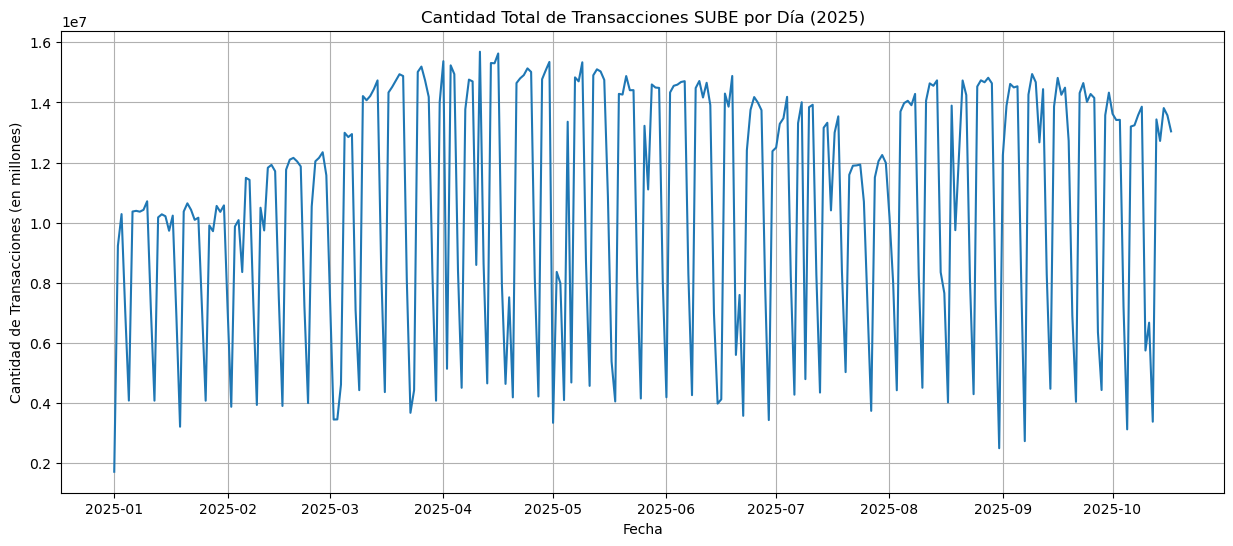

In [6]:

print("\n--- Generando Gráfico de Serie Temporal (EDA) ---")
plt.figure(figsize=(15, 6))
plt.plot(df_diario.index, df_diario['cantidad_total'])
plt.title('Cantidad Total de Transacciones SUBE por Día (2025)')
plt.xlabel('Fecha')
plt.ylabel('Cantidad de Transacciones (en millones)')
plt.grid(True)
plt.show()

**Conclusiones Clave del Análisis Exploratorio:**


1.  **Estacionalidad Semanal:** Se observa un patrón repetitivo de picos y valles, que corresponden a los días de semana (picos) y fines de semana (valles).
2.  **Feriados:** Se identifican caídas abruptas (valles atípicos) que son mucho más profundas que las de un fin de semana normal (ej. 2025-01-01).
3.  **Tendencia:** Hay una tendencia general al alza desde enero hasta marzo, que luego se estabiliza.

Basado en esto, se crearán dos modelos: un **Modelo Base** solo con patrones temporales, y un **Modelo Mejorado** que incluya los feriados.

### 3. Modelo Base (Sin Feriados)

Primero, se crea un modelo base utilizando solo características temporales y de retraso, para establecer una métrica inicial.

--- Modelo Base - MAE: 1,024,358 transacciones ---


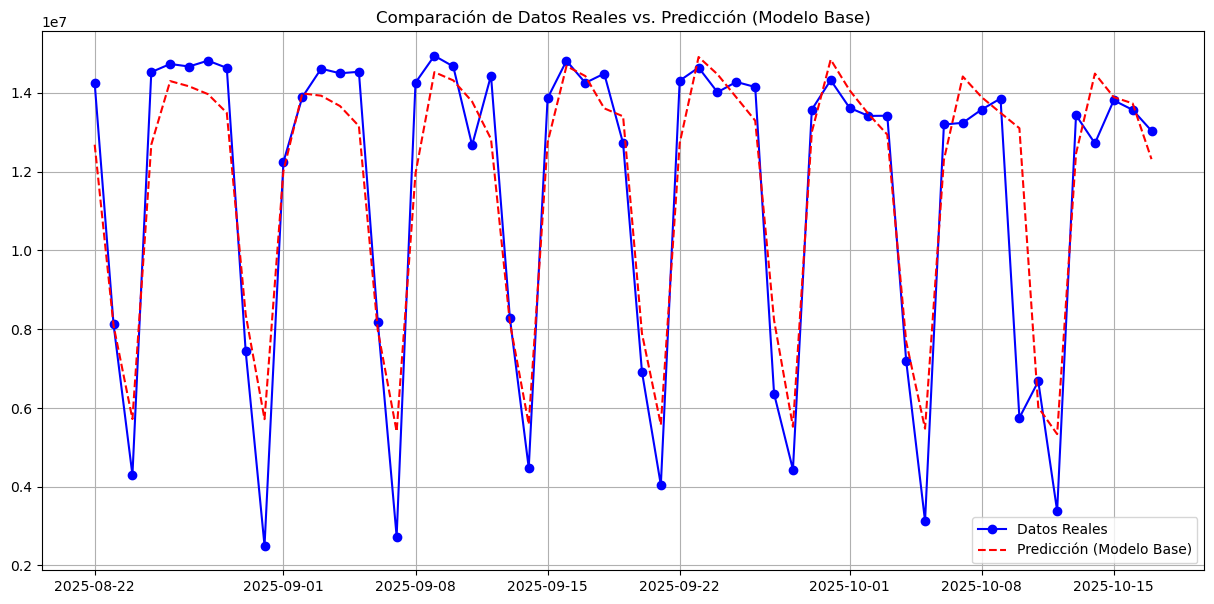

In [7]:
# --- Feature Engineering (Base) ---
df_base = df_diario.copy()
df_base['dia_semana'] = df_base.index.dayofweek
df_base['mes'] = df_base.index.month
df_base['dia_del_anio'] = df_base.index.dayofyear
df_base['es_finde'] = (df_base['dia_semana'] >= 5).astype(int)
df_base['lag_1_dia'] = df_base['cantidad_total'].shift(1)
df_base['lag_7_dias'] = df_base['cantidad_total'].shift(7)
df_base = df_base.dropna()

features_base = ['dia_semana', 'mes', 'dia_del_anio', 'es_finde', 'lag_1_dia', 'lag_7_dias']
target_base = 'cantidad_total'

X_base = df_base[features_base]
y_base = df_base[target_base]

# --- Split y Scale (Base) ---
corte_idx_base = int(len(X_base) * 0.8)
X_train_base, X_test_base = X_base.iloc[:corte_idx_base], X_base.iloc[corte_idx_base:]
y_train_base, y_test_base = y_base.iloc[:corte_idx_base], y_base.iloc[corte_idx_base:]

scaler_base = StandardScaler()
X_train_base_scaled = scaler_base.fit_transform(X_train_base)
X_test_base_scaled = scaler_base.transform(X_test_base)

# ---  Train y Evaluate (Base) ---
# Se prueba solo Regresión Lineal como base
modelo_lineal_base = LinearRegression()
modelo_lineal_base.fit(X_train_base_scaled, y_train_base)

y_pred_base = modelo_lineal_base.predict(X_test_base_scaled)
mae_base = mean_absolute_error(y_test_base, y_pred_base)
print(f"--- Modelo Base - MAE: {mae_base:,.0f} transacciones ---")

# ---  Visualización y Análisis (Base) ---
plt.figure(figsize=(15, 7))
plt.plot(y_test_base.index, y_test_base, label='Datos Reales', color='blue', marker='o')
plt.plot(y_test_base.index, y_pred_base, label='Predicción (Modelo Base)', color='red', linestyle='--')
plt.title('Comparación de Datos Reales vs. Predicción (Modelo Base)')
plt.legend()
plt.grid(True)
plt.show()

**Conclusión del Modelo Base:**

El MAE es de **~1.02M transacciones**. El gráfico muestra que, si bien el modelo captura bien la estacionalidad semanal, **falla sistemáticamente en los valles profundos** (feriados), prediciendo valores mucho más altos de lo que realmente ocurrieron.

Esto justifica la necesidad de agregar explícitamente los feriados como característica.

### 4. Modelo Mejorado (Con Feriados)

Basado en el análisis anterior, se crea un nuevo set de características que incluye los feriados de Argentina 2025.

Característica 'es_feriado' y 'lags' creadas.

---  Boxplot (EDA) para 'es_feriado' ---


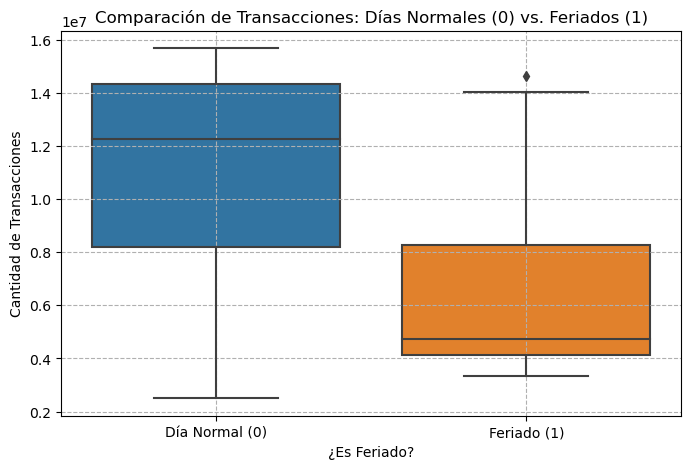

In [8]:
# --- Feature Engineering (Mejorado) ---
df_diario_f = df_diario.copy()

feriados_2025 = [
    '2025-01-01', '2025-03-03', '2025-03-04', '2025-03-24', '2025-04-02', 
    '2025-04-17', '2025-04-18', '2025-05-01', '2025-05-02', '2025-05-25', 
    '2025-06-16', '2025-06-20', '2025-07-09', '2025-08-15', '2025-08-17',
    '2025-09-23', '2025-09-24', '2025-10-02', '2025-10-12', '2025-11-21', 
    '2025-11-24', '2025-12-08', '2025-12-25'
]
feriados_dt = pd.to_datetime(feriados_2025)

# Crear todas las características, incluyendo la nueva
df_diario_f['dia_semana'] = df_diario_f.index.dayofweek
df_diario_f['mes'] = df_diario_f.index.month
df_diario_f['es_finde'] = (df_diario_f['dia_semana'] >= 5).astype(int)
df_diario_f['es_feriado'] = df_diario_f.index.isin(feriados_dt).astype(int) # <-- ¡LA NUEVA!
df_diario_f['lag_1_dia'] = df_diario_f['cantidad_total'].shift(1)
df_diario_f['lag_7_dias'] = df_diario_f['cantidad_total'].shift(7)
df_diario_f = df_diario_f.dropna()

print("Característica 'es_feriado' y 'lags' creadas.")

# ---  EDA de la nueva característica ---
print("\n---  Boxplot (EDA) para 'es_feriado' ---")
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_diario_f, x='es_feriado', y='cantidad_total')
plt.title('Comparación de Transacciones: Días Normales (0) vs. Feriados (1)')
plt.xlabel('¿Es Feriado?')
plt.ylabel('Cantidad de Transacciones')
plt.xticks([0, 1], ['Día Normal (0)', 'Feriado (1)'])
plt.grid(True, linestyle='--')
plt.show()

El Boxplot valida la hipótesis: la media de transacciones en feriados es drásticamente menor, justificando esta característica.

Ahora se procede a entrenar y evaluar los 3 modelos (Lineal, Árbol y SVR) con este nuevo set de datos.

In [9]:
# ---  Split y Scale (Mejorado) ---
print("--- Dividiendo datos (80% Train, 20% Test) ---")
features = ['dia_semana', 'mes', 'es_finde', 'es_feriado', 'lag_1_dia', 'lag_7_dias']
target = 'cantidad_total'
X = df_diario_f[features]
y = df_diario_f[target]

corte_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:corte_idx], X.iloc[corte_idx:]
y_train, y_test = y.iloc[:corte_idx], y.iloc[corte_idx:]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print("Datos mejorados listos.")

# ---  Entrenamiento de Modelos (Mejorado) ---
print("--- Entrenando modelos... ---")
modelo_lineal = LinearRegression().fit(X_train_scaled, y_train)
modelo_arbol = DecisionTreeRegressor(random_state=42).fit(X_train, y_train)
modelo_svr = SVR(kernel='rbf').fit(X_train_scaled, y_train)
print("Modelos re-entrenados.")

# ---  Evaluación de Modelos (Mejorado) ---
print("--- Evaluando modelos... ---")

y_pred_lineal = modelo_lineal.predict(X_test_scaled)
y_pred_arbol = modelo_arbol.predict(X_test)
y_pred_svr = modelo_svr.predict(X_test_scaled)

print("\n--- Resultados de Métricas (CON Feriados) ---")
mae_lineal = mean_absolute_error(y_test, y_pred_lineal)
rmse_lineal = np.sqrt(mean_squared_error(y_test, y_pred_lineal))
print(f"Modelo 1 - Regresión Lineal:\n  MAE: {mae_lineal:,.0f} | RMSE: {rmse_lineal:,.0f}")

mae_arbol = mean_absolute_error(y_test, y_pred_arbol)
rmse_arbol = np.sqrt(mean_squared_error(y_test, y_pred_arbol))
print(f"Modelo 2 - Árbol de Decisión:\n  MAE: {mae_arbol:,.0f} | RMSE: {rmse_arbol:,.0f}")

mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
print(f"Modelo 3 - SVR:\n  MAE: {mae_svr:,.0f} | RMSE: {mae_svr:,.0f}")

--- Dividiendo datos (80% Train, 20% Test) ---
Datos mejorados listos.
--- Entrenando modelos... ---
Modelos re-entrenados.
--- Evaluando modelos... ---

--- Resultados de Métricas (CON Feriados) ---
Modelo 1 - Regresión Lineal:
  MAE: 1,344,915 | RMSE: 2,176,503
Modelo 2 - Árbol de Decisión:
  MAE: 1,281,233 | RMSE: 2,545,707
Modelo 3 - SVR:
  MAE: 3,452,608 | RMSE: 3,452,608


### 5. Conclusión y Análisis del Modelo Final


El análisis de métricas muestra que, al incluir feriados, el **Árbol de Decisión** se convierte en el mejor modelo, con el MAE más bajo (`~1.28M`).


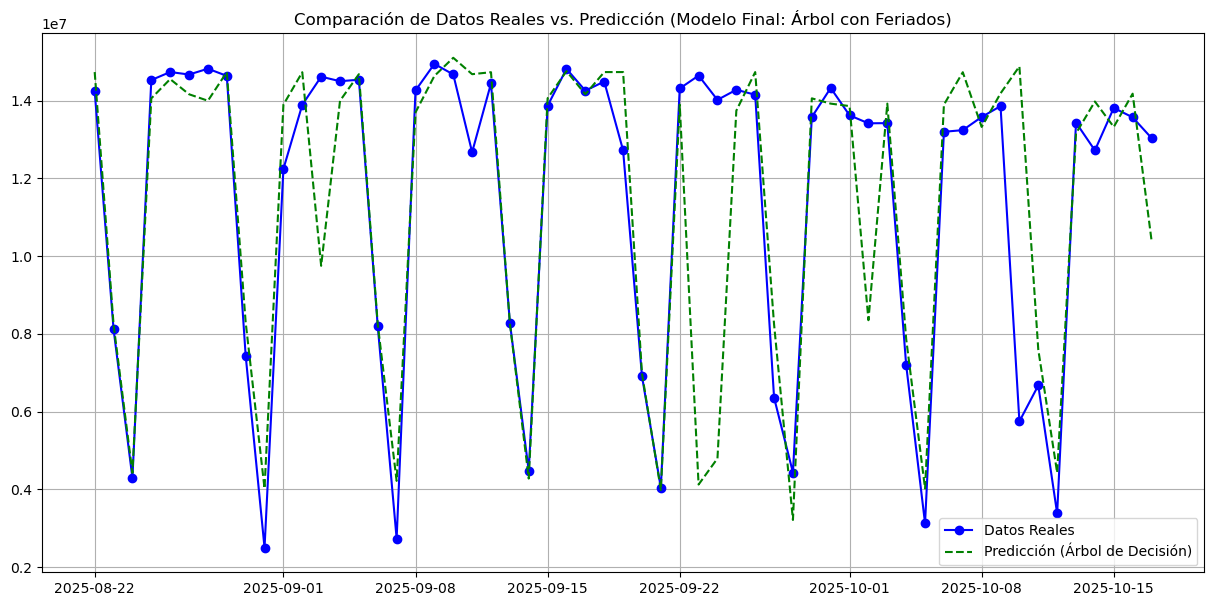

In [10]:
# --- Visualización del Modelo Final ---
plt.figure(figsize=(15, 7))
plt.plot(y_test.index, y_test, label='Datos Reales', color='blue', marker='o')
plt.plot(y_test.index, y_pred_arbol, label='Predicción (Árbol de Decisión)', color='green', linestyle='--')
plt.title('Comparación de Datos Reales vs. Predicción (Modelo Final: Árbol con Feriados)')
plt.legend()
plt.grid(True)
plt.show()


--- Importancia de Características (Árbol de Decisión) ---
  Caracteristica  Importancia
0     dia_semana     0.583434
3     es_feriado     0.187624
5     lag_7_dias     0.088411
1            mes     0.079460
4      lag_1_dia     0.061072
2       es_finde     0.000000


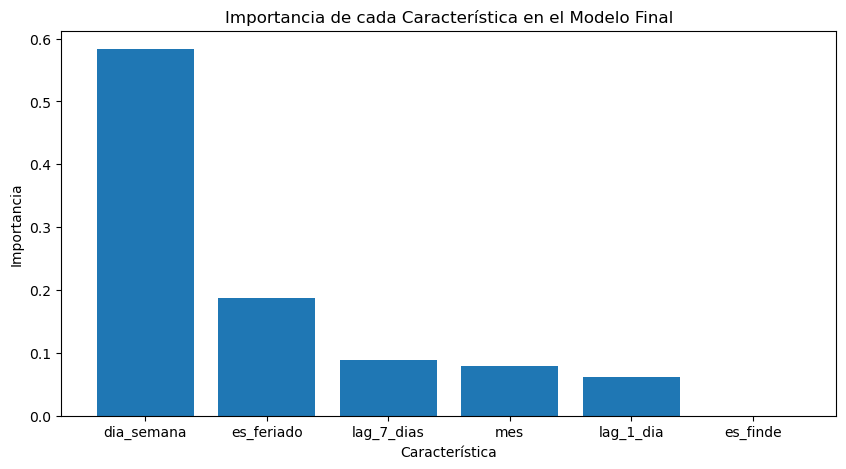

In [11]:
# --- Interpretación del Modelo Final ---
print("\n--- Importancia de Características (Árbol de Decisión) ---")

importancias = modelo_arbol.feature_importances_
features_df = pd.DataFrame({'Caracteristica': features, 'Importancia': importancias})
features_df = features_df.sort_values(by='Importancia', ascending=False)
print(features_df)

plt.figure(figsize=(10, 5))
plt.bar(features_df['Caracteristica'], features_df['Importancia'])
plt.title('Importancia de cada Característica en el Modelo Final')
plt.xlabel('Característica')
plt.ylabel('Importancia')
plt.show()

**Conclusiones Finales:**

El objetivo general se cumplió. Se desarrolló un modelo de `Arbol de decisión` capaz de predecir la demanda de transporte.

1.  **Iteración y Mejora:** El modelo base (`Regresión lineal`) obtuvo un MAE de ~1.02M, pero falló en predecir feriados.
2.  **Modelo Ganador:** Al agregar la característica `es_feriado` (validada con un boxplot), un `Arbol de decisión` superó al modelo lineal, logrando un MAE de **1.28M**.
3.  **Interpretación:** El análisis de `feature_importances_` revela que el modelo basa sus predicciones principalmente en:
    * **`dia_semana` (58.3%)**
    * **`es_feriado` (18.8%)**
    * **`lag_7_dias` (8.8%)**

El proyecto demuestra que una correcta ingeniería de características (identificar `dia_semana` y `es_feriado`) es más importante que la elección del algoritmo en sí, y que el Árbol de Decisión fue el más apto para modelar estas "reglas" del calendario.